**Author's Note (2022-09-05):** *As of the official release of [PyMC version 4.0](https://www.pymc.io/blog/v4_announcement.html), the current stable version of PyMC now supports multivariate distributions.  Inference using these is generally much more efficient than any of the workaround parameterizations presented in this post.  For those still itnerested in a closed-form solution for the Cholesky decomposition this post computes using SymPy, consult [this subsequent post](https://austinrochford.com/posts/exch-chol-closed.html)*

For an upcoming analysis of the fighting skills of hockey players, I've fallen down a rabbit hole comparing several different parametrizations for estimating the covariance parameter of latent [exchangeable normal random variables](https://en.wikipedia.org/wiki/Exchangeable_random_variables) using [PyMC](https://docs.pymc.io/en/stable/).  After working out which parameterization was most efficient for my model, I've decided that this derivation is interesting enough to merit its own post.

<center>
<table>
    <tr>
        <td><img alt="Alice falling down a rabbit hole" src="https://c.tenor.com/E14SgWRxUoMAAAAC/alice-rabbithole.gif"></td>
        <td><img alt="Bivariate normal distribution" src="https://upload.wikimedia.org/wikipedia/commons/5/57/Multivariate_Gaussian.png" width=350></td>
        <td><img alt="Philadelphia Flyers goalie punching Washington Capitals goalie" src="http://www.trbimg.com/img-5b93e92c/turbine/ct-xpm-2013-11-01-chi-emery-starts-goalie-fight-in-flyers-loss-20131101" width=350></td>
    </tr>
    <tr>
        <td colspan=3><center>Alice in Wonderland, statistics, and hockey: three of my favorite things</center></td>
    </tr>
</table>
</center>

## Exchangeable random variables

Recall that a sequence of random variables $X_1, \ldots, X_T$ is [exchangeable](https://en.wikipedia.org/wiki/Exchangeable_random_variables) if its joint distribution is invariant under permutations of the indicues.  More concretely, this sequence is exchangeable if for every permutation of the indices (a bijective function $\tau: \{1, \ldots T\} \to \{1, \ldots T\}$), $X_1, \ldots, X_T$ and $X_{\tau(1)}, \ldots, X_{\tau(T)}$ have the same joint distribution.

Exchangeabile variables arise in many situations, and most importantly for our situation, lead to interesting covariance/correlation structures.  It is evident from the definition that exchangeable random variables must have the same mean and variance, so we define $\mu = \mathbb{E}(X_t)$ and $\sigma^2 = \mathbb{Var}(X_t)$.  It is also evident that each pair has the same covariance, so we define the Pearson correlation coefficient

$$\rho = \frac{\mathbb{Cov}(X_s, X_t)}{\sigma^2}.$$

This post will focus on the sampling performance for estimating the posterior distribution of $\rho$ using various mathematically equivalent parameterizations.

Exchangeability imposes a restriction on how anticorrelated these random variables can be, as the following calculation shows.  We know that variance must be nonnegative, so by the [bilinearity of covariance](https://en.wikipedia.org/wiki/Covariance#Covariance_of_linear_combinations)

$$
\begin{align}
    0
        & \leq \mathbb{Var}\left(\sum_{t = 1}^T X_i\right) \\
        & = \sum_{t = 1}^T \mathbb{Var}(X_i) + 2 \sum_{t = 1}^T \sum_{s = 1}^t \mathbb{Cov}(X_s, X_t) \\
        & = T \sigma^2 + T (T - 1) \rho \sigma^2 \\
        & = (1 + (T - 1) \rho) \cdot T \sigma^2.
\end{align}
$$

Since $T \sigma^2 \geq 0$ by definition, we must have

$$1 + (T - 1) \rho \geq 0.$$

Solving this inequality gives

$$\rho \geq -\frac{1}{T - 1},$$

so exchangeable random variables cannot be too anticorrelated, and how anticorrelated they can be depends on the length of the sequence.  In the limit $T \to \infty$, we see that an infinite sequence of exchangeable random variables must have nonnegative Pearson correlation.

This constraint on the range of possible Pearson correlations for an exchangeable sequence is of particular interest for my hockey application as I want to examine the evidence that the latent fighting "skill" of players is uncorrelated across seasons.  (The word "skill" appears in quotes here because if there is no season-over-season correlation, we are probably not modeling a true latent skill.)

We will keep this constraint in mind as we explore the sampling efficiency of various parametrizations of latent exchangeable normal random variables in the following sections.

## Generating the data

For benchmarking purposes, we will simulate data sets drawn from a population based on latent normal parameters that are exchangeable.  In order to focus on estimating the Pearson correlation, $\rho$, we will assume all random variables have unit scale, $\sigma = 1$.  These calculations extend easily to the case of an abritrary scale.

First we make the necessary Python imports and do some light housekeeping.

In [1]:
from contextlib import contextmanager
from enum import Enum
from fastprogress.fastprogress import progress_bar
import json
import logging
from pathlib import Path
from toolz import compose, valmap

In [2]:
from aesara import tensor as at
import arviz as az
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import sympy as sym

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


In [3]:
FIG_WIDTH = 8
FIG_HEIGHT = 6
mpl.rcParams['figure.figsize'] = (FIG_WIDTH, FIG_HEIGHT)

sns.set(color_codes=True)

For the purposes of these simulations we will set $T = 4$, small enough so we can visualize covariance matrices using [SymPy](https://www.sympy.org/en/index.html), but large enough that I don't want to do the necessary calcuations by hand.

In [4]:
T = 4

We generate $K = 100$ random latent $T$-vectors from an exchangeable normal distribution with mean zero, unit scale, and Pearson correlation $\rho$, so the covariance matrix is

$$
\Sigma_{\rho}
    = \begin{pmatrix}
        1 & \rho & \cdots & \rho & \rho \\
        \rho & 1 & \cdots & \rho & \rho \\
        \rho & \rho & \cdots & 1 & \rho \\
        \rho & \rho & \cdots & \rho & 1
    \end{pmatrix} \in \mathbb{R}^{T \times T}
$$

and $\mathbf{\mu}_1, \ldots, \mathbf{\mu}_K \sim N\left(0, \Sigma_{\rho}\right)$.  For the moment we will use $\rho = 0.5$.

In [5]:
RHO = 0.5
K = 100

In [6]:
SEED = 123456789

rng = np.random.default_rng(SEED)

In [7]:
Sigma_rho = np.eye(T) + RHO * (1 - np.eye(T))
mu = rng.multivariate_normal(np.zeros(T), Sigma_rho, size=K)

We see that these samples have the desired covariance structure (allowing for sampling noise on the order of $\frac{1}{\sqrt{K}} = 0.1$).

In [8]:
np.corrcoef(mu, rowvar=False)

array([[1.        , 0.43203461, 0.42611009, 0.52428711],
       [0.43203461, 1.        , 0.49784241, 0.52027976],
       [0.42611009, 0.49784241, 1.        , 0.48151274],
       [0.52428711, 0.52027976, 0.48151274, 1.        ]])

We now generate observations. Each of these $\mathbf{\mu}_k$ represent the latent mean of a group. We will generate $n_K = 20$ observations for group, $\mathbf{x}_1, \ldots, \mathbf{x}_{K \cdot n_K} \in \mathbb{R}^T$ with distribution $x_i \sim N\left(\mathbf{\mu}_{k(i)}, \mathbb{I}_T\right)$ where $k(i) = \left\lfloor \frac{i}{n_K} \right\rfloor$ is the group of the $i$-th observation and $\mathbb{I}_T$ is the T-dimensional identity matrix.

In [9]:
n_K = 20
k_i = np.arange(K * n_K) // n_K

In [10]:
x = mu[k_i] + rng.normal(size=(K * n_K, T))

Calculating the covariance of $x_{i, s} = \mu_{i, s} + \varepsilon_{i, s}$ and $x_{i, t} = \mu_{i, t} + \varepsilon_{i, t}$, with $\varepsilon_{i, t} \sim N(0, 1)$ i.i.d as above, we get

$$
\begin{align}
    \mathbb{Cov}(x_{i, s}, x_{i, t})
        & = \mathbb{Cov}(\mu_{i, s} + \varepsilon_{i, s}, \mu_{i, t} + \varepsilon_{i, t}) \\
        & = \mathbb{Cov}(\mu_{i, s}, \mu_{i, t}) + \mathbb{Cov}(\varepsilon_{i, s}, \varepsilon_{i, t}) \\
        & = \begin{cases}
            \sigma^2 + 1  & \text{if } s = t \\
            \rho \sigma^2 & \text{if } s \neq t
        \end{cases} \\
        & = \begin{cases}
            2  & \text{if } s = t \\
            0.5 & \text{if } s \neq t
        \end{cases}.
\end{align}
$$

Therefore we get a Pearson correlation of

$$
\begin{align}
    \mathbb{Corr}(x_{i, s}, x_{i, t})
        & = \frac{\mathbb{Cov}(x_{i, s}, x_{i, t})}{\sqrt{\mathbb{Cov}(x_{i, s}, x_{i, s})} \cdot \sqrt{\mathbb{Cov}(x_{i, t}, x_{i, t})}} \\
        & = \frac{0.5}{\sqrt{2} \cdot \sqrt{2}} \\
        & = 0.25
\end{align}
$$

for $s \neq t$.

This correlation is borne out in our simulated data.

In [11]:
np.corrcoef(x, rowvar=False)

array([[1.        , 0.2343107 , 0.19670175, 0.24605147],
       [0.2343107 , 1.        , 0.22697497, 0.23203603],
       [0.19670175, 0.22697497, 1.        , 0.24862999],
       [0.24605147, 0.23203603, 0.24862999, 1.        ]])

In order to study the sampling performance of different parametrizations for a variety of values of $\rho$, the following function that generates data as above given $\rho$ will be useful.

In [12]:
def generate_data(rho, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    Sigma_rho = np.eye(T) + rho * (1 - np.eye(T))
    mu = rng.multivariate_normal(np.zeros(T), Sigma_rho, size=K)
    
    return mu[k_i] + rng.normal(size=(K * n_K, T))

## Parametrizations for inference with exchangeble multivarial normal random variables

For the rest of this post we will focus exclusively on the 
 
When we imported `pymc` we got the following warning:

> `You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3`

One of the key features the development version of PyMC v4 lacks as of the commit that was installed in the Docker container I am composing this post on,

In [13]:
try:
    pm_path = Path(pm.__path__[0])
    dist_info_path, = pm_path.parent.glob("pymc-*.dist-info")

    with open(dist_info_path / "direct_url.json", 'r') as src:
        direct_url_data = json.load(src)

    print(direct_url_data["vcs_info"]["commit_id"])
except:
    print("Nothing to see here")

598dd9de2b818a58480071720a9f3da63177be89


is a working multivariate normal implementation.  This lack is not a true problem as we can quickly implement a workaround sufficient for our situation that will be roughly in line with the eventual PyMC v4 implementation.

### The Cholesky decomposition

Recall that if $\mathbf{\mu} \in \mathbb{R}^T$ and $\Sigma \in \mathbb{R}^{T \times T}$ is a [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix) covariance matrix and $\mathbf{x} \sim N(\mathbf{\mu}, \Sigma)$ then the density of $\mathbf{x}$ is

$$
f\left(\mathbf{x}\ | \mathbf{\mu}, \Sigma\right)
    = (2 \pi)^{-\frac{T}{2}} \cdot \left|\Sigma\right|^{-\frac{1}{2}} \cdot \exp \left(-\frac{(\mathbf{x} - \mathbf{\mu})^{\top} \Sigma^{-1}(\mathbf{x} - \mathbf{\mu})}{2}\right).
$$

The [quadratic form](https://en.wikipedia.org/wiki/Quadratic_form) $(\mathbf{x} - \mathbf{\mu})^{\top} \Sigma^{-1}(\mathbf{x} - \mathbf{\mu})$ is suggestive.  If we can decompose the covariance matrix $\Sigma = L L^{\top}$ where $L$ is sufficiently nice, we can rewrite the quadratic form as

$$
(\mathbf{x} - \mathbf{\mu})^{\top} \Sigma^{-1}(\mathbf{x} - \mathbf{\mu})
    = (L^{-1} (\mathbf{x} - \mathbf{\mu}))^{\top} (L^{-1} (\mathbf{x} - \mathbf{\mu})).
$$

If, in particular, $L$ is lower diagonal, it is relatively easy to solve the linear system $L \mathbf{z} = \mathbf{x} - \mathbf{\mu}$ using [back subtitution](https://en.wikipedia.org/wiki/Triangular_matrix#Forward_and_back_substitution).  The determinant in the density is also easy to calculate because $|\Sigma|^{-\frac{1}{2}} = |L|^{-1}$, and the determinant of a triangular matrix is just the product of its diagonal entries.  Fortunately such a decomposition, the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition), is well-known and has been extensively studied.  Together with the Cholesky decomposition, the following fact gives an easy way to generate samples from a multivariate normal distribution with arbitrary covariance matrix.

**Theorem** Let $\mathbf{z} \in \mathbb{R}^n$ have components drawn from a standard normal distribution, $z_1, \ldots z_n \overset{\text{i.i.d.}}{\sim} N(0, 1)$.  Let $A \in \mathbb{R}^{m \times n}$.  Then $A \mathbf{z} \in \mathbb{R}^m$ has distribution $A \mathbf{z} \sim N(0, A^{\top}A)$.

Therefore if we want to generate samples from an $N(0, \Sigma)$ distribution, we can calculate the Cholesky decomposition of the covariance matrix, $\Sigma = L L^{\top}$, generate samples $\mathbf{z}_i \sim N(0, \mathbb{I})$ and multiply to get $L \mathbf{z}_i \sim N(0, \Sigma)$.

This post will compare two ways of calculating the Cholesky factorization of $\Sigma$ in the case that the normal random variables are exchangeable with a third parametrization for cases where $\rho \geq 0$ through the lens of sampling efficiency using Hamiltonian Monte Carlo sampling implemented in PyMC.

### General Cholesky decomposition

PyMC uses [Aesara](https://aesara.readthedocs.io/en/latest/index.html) as its underlying tensor computation/differentiation engine.  Conveniently, Aesara implements a cholesky decomposition that PyMC then wraps in the function `pm.distributions.multivariate.cholesky` that can be applied to matrices of random variables.

We begin with a uniform prior on our correlation coefficient in the permissible range $-\frac{1}{T - 1} \leq \rho < 1$.

In [14]:
with pm.Model(rng_seeder=SEED) as gen_model:
    ρ = pm.Uniform("ρ", -1. / (T - 1), 1.)

We then build the associated covariance matrix

$$
\Sigma_{\rho}
    = \begin{pmatrix}
        1 & \rho & \cdots & \rho & \rho \\
        \rho & 1 & \cdots & \rho & \rho \\
        \rho & \rho & \cdots & 1 & \rho \\
        \rho & \rho & \cdots & \rho & 1
    \end{pmatrix} \in \mathbb{R}^{T \times T}
$$

and compute its Cholesky decomposition.

In [15]:
def get_corr_mat(rho, n):
    return np.eye(n) + rho * (1 - np.eye(n))

In [16]:
with gen_model:
    Σ_ρ = get_corr_mat(ρ, T)
    L = pm.distributions.multivariate.cholesky(Σ_ρ)

Following the plan laid out in the theorem above, we then sample $\mathbf{z}_1, \ldots, \mathbf{z}_K \in \mathbb{R}^T$ having standard normally distributed entries, and transform them to to $\mathbf{\mu}_k = L \mathbf{z}_k \sim N\left(0, \Sigma_{\rho}\right)$.

In [17]:
with gen_model:
    z = pm.Normal("z", 0., 1., shape=(K, T))
    μ = z.dot(L.T)

Finally we specify the likelihood of the observed data.

In [18]:
with gen_model:
    pm.Normal("obs", μ[k_i], 1., observed=pm.Data("x", x))

We now sample from the model's posterior distribution.

In [19]:
CORES = 3

SAMPLE_KWARGS = {
    'cores': CORES,
    'random_seed': [SEED + i for i in range(CORES)]
}

In [20]:
with gen_model:
    gen_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ρ, z]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 245 seconds.
The number of effective samples is smaller than 25% for some parameters.


Note the warning about small effective sample size.  Effective samples per second will be the key quantity to consider when we benchmark our parametrizations against each other.

Plotting the posterior distribution of $\rho$, we see that the true value of 0.5 is comfortably inside the high posterior density interval.

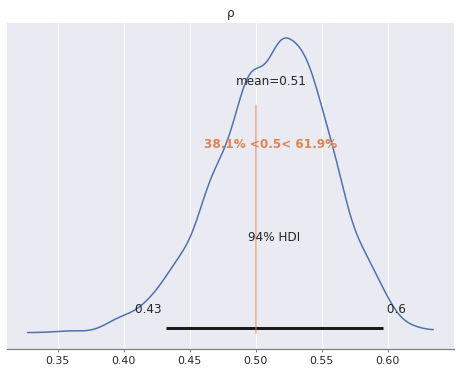

In [21]:
az.plot_posterior(gen_trace, var_names="ρ", ref_val=0.5);

### Cholesky decomposition for excheangeable normal random variables

One advantage of the previous parametrization is its generality; nowhere did we rely on the fact that the random variables were exchangeable.  While pursuing my hockey fight research, I was curious if we can improve upon the sampling performance by taking advantage of the fact that exchangeable normal random variables lead to the highly structured covariance matrix

$$
\begin{align}
    \Sigma_{\rho} = \begin{pmatrix}
        1 & \rho & \cdots & \rho & \rho \\
        \rho & 1 & \cdots & \rho & \rho \\
        \rho & \rho & \cdots & 1 & \rho \\
        \rho & \rho & \cdots & \rho & 1
    \end{pmatrix}.
\end{align}
$$

Therefore the question is, can we exploit this structure to come up with a simple (enough) closed form expression to facilitate faster sampling?  The answer was not obvious to me, but I was hopeful.  Prior to considering this question I had never calculated a Cholesky decomposition by hand, and I still have not.  To avoid the tedious work of manual calculations, we can lean on [SymPy](https://www.sympy.org/en/index.html).

Below we generate a matrix the $T \times T$ covariance matrix for our situation (exchangeable normal random variables with unit scale and $T = 4$).

In [22]:
def get_corr_mat_sympy(rho, n):
    return sym.eye(n) + rho * (sym.ones(n, n) - sym.eye(n))

In [23]:
rho = sym.var(r"\rho")

In [24]:
Sigma_rho_sym = get_corr_mat_sympy(rho, T)

In [25]:
Sigma_rho_sym

Matrix([
[   1, \rho, \rho, \rho],
[\rho,    1, \rho, \rho],
[\rho, \rho,    1, \rho],
[\rho, \rho, \rho,    1]])

We can ask SymPy for this matrix's Cholesky decomposition and try to spot useful patterns.

In [26]:
L_sym = Sigma_rho_sym.cholesky(hermitian=False)

In [27]:
L_sym

Matrix([
[   1,                                   0,                                                                                                              0,                                                                                                                                                                       0],
[\rho,                   sqrt(1 - \rho**2),                                                                                                              0,                                                                                                                                                                       0],
[\rho, (-\rho**2 + \rho)/sqrt(1 - \rho**2),                                                        sqrt(-\rho**2 + 1 - (-\rho**2 + \rho)**2/(1 - \rho**2)),                                                                                                                                                                       0],
[\rho, (-\rho

One thing I notice immediately is that I am glad I did not calculate this by hand.  Another important point to notice is that each column has at most two unique (nonzero) entries:

1. the diagonal entry, and
2. the entry below the diagonal that is repeated to fill the rest of the column.

For a $T \times T$ covariance matrix, that means that there are only $2 T - 1$ unique entries to calculate, rather than $\frac{T (T - 1)}{2}$, a significant reduction.  I suspect, but also have not rigorously shown that these values can be calculated in less than the cubic [time required](https://en.wikipedia.org/wiki/Cholesky_decomposition#Computation) for the Cholesky decomposition of an arbitrary positive definite matrix.

While there is a pattern here that we could manually implement, we can be lazy and use SymPy's [`lambdify`](https://docs.sympy.org/latest/modules/utilities/lambdify.html#sympy.utilities.lambdify.lambdify) and a small Aesara bookkeeping function to convert the SymPy computational graph for the above decomposition into an Aesara function that can be used in a PyMC model.

In [28]:
def to_aesara(mat):
    return at.stack(
        [at.stack(row, axis=0) for row in mat],
        axis=0
    )

In [29]:
exch_chol = compose(to_aesara, sym.lambdify(rho, L_sym))

Except for the calculation of the Cholesky decomposition, every aspect of this model is the same as in the previous one.

In [30]:
with pm.Model(rng_seeder=SEED) as exch_model:
    ρ = pm.Uniform("ρ", -1. / (T - 1), 1.)
    L = exch_chol(ρ)
    
    z = pm.Normal("z", 0., 1., shape=(K, T))
    μ = z.dot(L.T)
    
    pm.Normal("obs", μ[k_i], 1., observed=pm.Data("x", x))

We now sample from this model's posterior distribution.

In [31]:
with exch_model:
    exch_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ρ, z]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


This model sampled much more quickly than the previous one, but we still see the effective sample size warning.

This model has done a very similar job of recovering the true correlation coefficient.

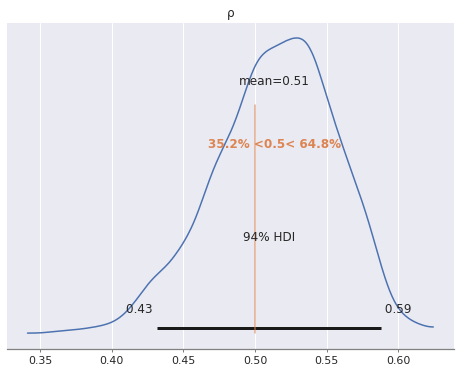

In [32]:
az.plot_posterior(exch_trace, var_names="ρ", ref_val=0.5);

Now that we have two models that produce roughly equivalent estimates, we can compare their sampling efficiency.

In [33]:
class ModelType(Enum):
    GEN_CHOL = "General Cholesky"
    EXCH_CHOL = "Exchangeable Cholesky"
    TWO_STAGE = "Two-stage"

In [34]:
half_traces = {
    ModelType.GEN_CHOL: gen_trace,
    ModelType.EXCH_CHOL: exch_trace
}

In [35]:
def get_ess_value(trace):
    return (az.ess(trace, var_names="ρ")
                   .to_array()
                   .values[0])

def get_sampling_time(trace):
    return (trace.sample_stats
                 .attrs
                 ["sampling_time"])

def get_bench_df(traces):
    df = pd.DataFrame.from_dict({
        "Effective sample size": valmap(get_ess_value, traces),
        "Sampling time": valmap(get_sampling_time, traces)
    })
    df["Effective samples per second"] = df["Effective sample size"] \
        / df["Sampling time"]
    df.index = df.index.map(lambda e: e.value)
    
    return df

Here we have a benchmark comparing the effective sample size, sampling time, and effective samples per second for these two models.

In [36]:
half_df = get_bench_df(half_traces)

In [37]:
half_df

,Effective sample size,Sampling time,Effective samples per second
General Cholesky,518.860706,244.747165,2.119987
Exchangeable Cholesky,530.852329,25.752860,20.613335


We see that these two models have produced essentially the same number of effective samples, but that the exchangeable model has produced this samples in a much shorter period of time than the general model, leading to a significantly higher effective samples per second.

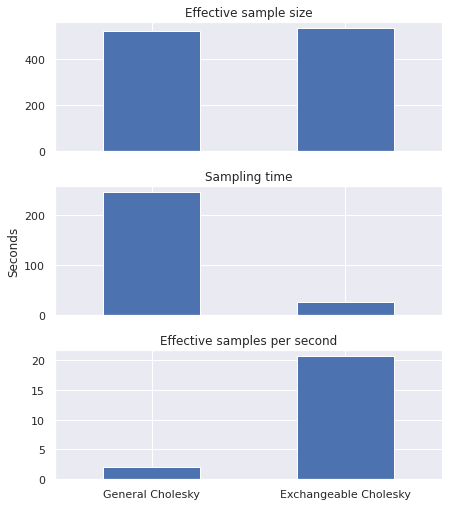

In [38]:
fig, axes = plt.subplots(nrows=3, sharex=True,
                         figsize=(0.8 * FIG_WIDTH, 1.2 * FIG_HEIGHT))


(half_df["Effective sample size"]
        .plot.bar(ax=axes[0]));
(half_df["Sampling time"]
        .plot.bar(ax=axes[1]));
(half_df["Effective samples per second"]
        .plot.bar(ax=axes[2], rot=False));

axes[1].set_ylabel("Seconds");

axes[0].set_title("Effective sample size");
axes[1].set_title("Sampling time");
axes[2].set_title("Effective samples per second");

fig.tight_layout()

Effective samples per second is the metric by which we will ultimately judge our parametrizations.

### Two-stage sampling for nonnegative correlations

There is one more approach that is worth including in this comparison.  If the correlation coefficient $\rho \geq 0$ we can produce samples with the desired covariance structure according to the following scheme.

1. Sample $w_1, \ldots z_K \sim N(0, 1)$.
2. Sample $z_{k, t} \sim N(0, 1)$ for $k = 1, \ldots, K$ and $t = 1, \ldots T$.
3. Set $\mu_{k, t} = \sqrt{\rho} \cdot w_k + \sqrt{1 - \rho} \cdot z_{k, t}$.

To see that these samples have the appropriate structure we calculate

$$
\begin{align}
    \mathbb{Cov}(\mu_{k, s}, \mu_{k, t})
        & = \mathbb{Cov}(\sqrt{\rho} \cdot w_k + \sqrt{1 - \rho} \cdot z_{k, s}, \sqrt{\rho} \cdot w_k + \sqrt{1 - \rho} \cdot z_{k, t}) \\
        & = \rho + (1 - \rho) \cdot \mathbb{Cov}(z_{k, s}, z_{k, t})
\end{align}
$$

by independence.  We have

$$
\mathbb{Cov}(z_{k, s}, z_{k, t}) = \begin{cases}
    1 & \text{if } s = t \\
    0 & \text{if } s \neq t
\end{cases},
$$

so

$$
\mathbb{Cov}(\mu_{k, s}, \mu_{k, t}) = \begin{cases}
    1 & \text{if } s = t \\
    \rho & \text{if } s \neq t
\end{cases}.
$$

It is clear from the $\sqrt{\rho}$ and $\sqrt{1 - \rho}$ terms why this sampling scheme requires $0 \leq \rho < 1$.

In [39]:
with pm.Model(rng_seeder=SEED) as two_stage_model:
    ρ = pm.Uniform("ρ", 0., 1.)

    z = pm.Normal("z", 0., 1., shape=(K, 1))
    w = pm.Normal("w", 0., 1., shape=(K, T))
    μ = at.sqrt(ρ) * z + at.sqrt(1 - ρ) * w
    
    pm.Normal("y_obs", μ[k_i], 1., observed=pm.Data("x", x))

We now sample from this model's posterior distribution.

In [40]:
with two_stage_model:
    half_traces[ModelType.TWO_STAGE] = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ρ, z, w]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 64 seconds.


Once again this model recovers the true correlation coefficient roughly as well as the others.

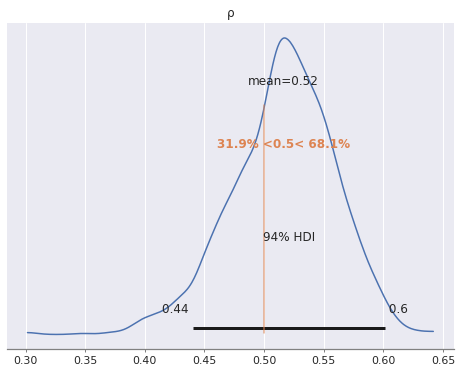

In [41]:
az.plot_posterior(half_traces[ModelType.TWO_STAGE],
                  var_names="ρ", ref_val=0.5);

Reevaluating our benchmarks with this model, we see that it samples slightly fewer effective samples per second than the exchangeable model, but is still significantly more efficient than the general model.

In [42]:
half_df = get_bench_df(half_traces)

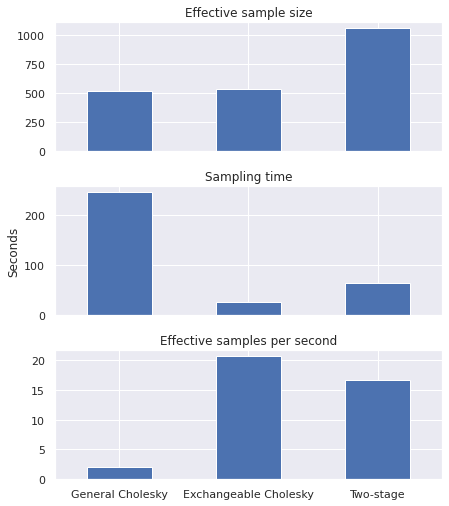

In [43]:
fig, axes = plt.subplots(nrows=3, sharex=True,
                         figsize=(0.8 * FIG_WIDTH, 1.2 * FIG_HEIGHT))

(half_df["Effective sample size"]
        .plot.bar(ax=axes[0]));
(half_df["Sampling time"]
        .plot.bar(ax=axes[1]));
(half_df["Effective samples per second"]
        .plot.bar(ax=axes[2], rot=False));

axes[1].set_ylabel("Seconds");

axes[0].set_title("Effective sample size");
axes[1].set_title("Sampling time");
axes[2].set_title("Effective samples per second");

fig.tight_layout()

Since the exchangeable model samples slightly more effective samples per second and can accomodate a wider range of correlation coefficients ($-\frac{1}{T - 1} \leq \rho < 1$ versus $0 \leq \rho <1$) when compared to the two-stage model, we are inclined to prefer this parameterization.

## Benchmarking

Before concluding that the exchangeable Cholesky parametrization is best for the hockey fight application, we will repeat the above exercise across a range of values of $\rho$ of interest.  We choose the left endpoint the interval, $-\frac{1}{T - 1} \leq \rho < 1$, a few values around zero to see how these parametrizations behave in the neighborhood of zero, and a few larger positive values.

In [44]:
RHOS = [-1 / (T - 1), -0.05, 0., 0.05, 0.5, 0.9]

In [45]:
data = {RHO: x}

for rho in RHOS:
    if rho not in data:
        data[rho] = generate_data(rho, rng=rng)

In [46]:
traces = {RHO: half_traces}

In [47]:
def can_use_model(rho, name):
    return rho >= 0 or name != ModelType.TWO_STAGE

def sample_models(rho, x, models, *,
                  sample_kwargs=SAMPLE_KWARGS,
                  progressbar=True):
    traces = {}
    
    for i, (name, model) in enumerate(models.items()):
        if can_use_model(rho, name):
            with model:
                pm.set_data({"x": x})
                traces[name] = pm.sample(progressbar=progressbar,
                                         **sample_kwargs)
            
    return traces

In [48]:
@contextmanager
def set_log_level(logger, level):
    orig_level = logger.getEffectiveLevel()
    
    try:
        logger.setLevel(level)
        yield
    finally:
        logger.setLevel(orig_level)

In [49]:
models = {
    ModelType.GEN_CHOL: gen_model,
    ModelType.EXCH_CHOL: exch_model,
    ModelType.TWO_STAGE: two_stage_model
}

In [50]:
pm_logger = logging.getLogger("pymc")

RHOS_prog = progress_bar(RHOS)

with set_log_level(pm_logger, logging.CRITICAL):
    for rho in RHOS_prog:
        RHOS_prog.comment = f"Sampling models for $\\rho = {rho:.2f}$"

        if rho not in traces:
            
            traces[rho] = sample_models(rho, data[rho], models,
                                        progressbar=False)

From these traces, we can get a combined benchmark data frame.

In [51]:
def add_rho_level(rho, df):
    return (df.assign(rho=rho)
              .rename_axis("model")
              .set_index("rho", append=True))

In [52]:
bench_dfs = valmap(get_bench_df, traces)
bench_df = (
    pd.concat((
        add_rho_level(rho, rho_df) for rho, rho_df in bench_dfs.items()
      ))
      .sort_index(level="rho")
)

In [53]:
bench_df.head()

,,Effective sample size,Sampling time,Effective samples per second
model,rho,,,
Exchangeable Cholesky,-0.333333,63.184842,24.983521,2.529061
General Cholesky,-0.333333,95.288883,243.715941,0.390983
Exchangeable Cholesky,-0.050000,364.477740,23.676677,15.393957
General Cholesky,-0.050000,341.109837,180.427612,1.890563
Exchangeable Cholesky,0.000000,371.375624,21.831124,17.011292


This analysis shows that, in every situation we have tested, the exchangeable Cholesky parameterization is preferable in terms of effective samples per second.

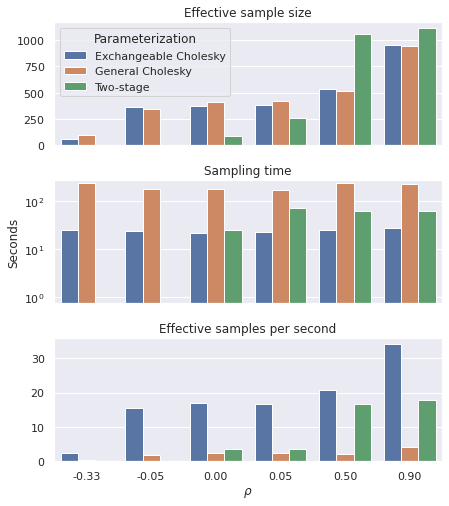

In [54]:
fig, axes = plt.subplots(nrows=3, sharex=True,
                         figsize=(0.8 * FIG_WIDTH, 1.2 * FIG_HEIGHT))

sns.barplot(
    x="rho",  y="Effective sample size",
    data=bench_df.reset_index(),
    hue="model", ax=axes[0]
);
sns.barplot(
    x="rho",  y="Sampling time",
    data=bench_df.reset_index(),
    hue="model", ax=axes[1]
);
sns.barplot(
    x="rho",  y="Effective samples per second",
    data=bench_df.reset_index(),
    hue="model", ax=axes[2]
);

axes[0].set_xlabel(None);
axes[1].set_xlabel(None);

axes[2].set_xticklabels([f"{rho:.2f}" for rho in RHOS]);
axes[2].set_xlabel(r"$\rho$");

axes[0].set_ylabel(None);

axes[1].set_yscale('log');
axes[1].set_ylim(bottom=0.75);
axes[1].set_yticks([1, 10, 100]);
axes[1].set_ylabel("Seconds");

axes[2].set_ylabel(None);

axes[0].set_title("Effective sample size");
axes[1].set_title("Sampling time");
axes[2].set_title("Effective samples per second");

axes[0].legend(loc="upper left", title="Parameterization");
axes[1].legend_.set(visible=False);
axes[2].legend_.set(visible=False);

fig.tight_layout()

Interestingly, the exchangeable parameterization outperforms the two-stage sampling approach by a wider margin in the limit $\rho \searrow 0$.

Of course if we wanted a really rigorous benchmark we would run inference in each of these situations many times to get a reliable average value and standard deviation for each of these metrics.  I am unfortunately impatient, and collecting this data has already taken quite a while, so this evidence is sufficient for me to prefer the exchangeable Cholesky parameterization in my hockey fight analysis.

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/8585e3b5d16768f5a1b710f4fb742ec2).

In [55]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Fri Nov 05 2021

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.28.0

json      : 2.0.9
logging   : 0.5.1.2
pymc      : 4.0.0
sympy     : 1.9
numpy     : 1.19.5
aesara    : 2.2.2
seaborn   : 0.11.2
pandas    : 1.3.3
matplotlib: 3.4.3
arviz     : 0.11.4

